# Trabajo Fin de Máster – Proyecto práctico

## Predicción de la ocurrencia de infarto cerebral (stroke.csv)

### Autor: Elisabetta Rivela

### 1. Librerías y configuración

In [55]:
# Instalamos / importamos todas las dependencias necesarias.

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             RocCurveDisplay)

from imblearn.over_sampling import SMOTE
from scipy.stats import randint, loguniform
import shap

import joblib
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 2. Carga de datos y vistazo inicial

In [56]:
DATA_PATH = "stroke.csv"  # Ruta al archivo

df = pd.read_csv(DATA_PATH)
df.set_index("id", inplace=True) 
print(f"Shape: {df.shape}")
df.head()

# Información del dataframe
df.info()
df.head()

Shape: (5110, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,6.700e+01,0,1,Yes,Private,Urban,2.287e+02,3.660e+01,formerly smoked,1
51676,Female,6.100e+01,0,0,Yes,Self-employed,Rural,2.022e+02,NaN,never smoked,1
31112,Male,8.000e+01,0,1,Yes,Private,Rural,1.059e+02,3.250e+01,never smoked,1
60182,Female,4.900e+01,0,0,Yes,Private,Urban,1.712e+02,3.440e+01,smokes,1
1665,Female,7.900e+01,1,0,Yes,Self-employed,Rural,1.741e+02,2.400e+01,never smoked,1


### 3. Análisis exploratorio de datos

In [57]:
target = "stroke"
num_cols = ["age", "avg_glucose_level", "bmi"]
cat_cols = ["gender", "hypertension", "heart_disease", "ever_married",
            "work_type", "Residence_type", "smoking_status"]

N = len(df)
n_pos = df[target].sum()
print(f"Prevalencia de {target}: {n_pos}/{N} = {n_pos/N:.2%}")

Prevalencia de stroke: 249/5110 = 4.87%


In [58]:
#  Missingness
missing = (df.isna().sum()
             .to_frame("n_missing")
             .assign(pct_missing=lambda x: 100 * x["n_missing"] / N))
print("\nValores ausentes (n y %):")
print(missing)



Valores ausentes (n y %):
                   n_missing  pct_missing
gender                     0    0.000e+00
age                        0    0.000e+00
hypertension               0    0.000e+00
heart_disease              0    0.000e+00
ever_married               0    0.000e+00
work_type                  0    0.000e+00
Residence_type             0    0.000e+00
avg_glucose_level          0    0.000e+00
bmi                      201    3.933e+00
smoking_status             0    0.000e+00
stroke                     0    0.000e+00


In [59]:
# Descriptivas para variables numéricas (global y por clase)
def mean_sd(s):
    return f"{s.mean():.2f} ± {s.std(ddof=1):.2f}"

def median_iqr(s):
    q1, q3 = s.quantile([0.25, 0.75])
    return f"{s.median():.2f} [{q1:.2f}–{q3:.2f}]"

rows = []
for col in num_cols:
    row = {
        "Variable": col,
        "All (n)": df[col].notna().sum(),
        "All (mean±sd)": mean_sd(df[col]),
        "All (median [IQR])": median_iqr(df[col]),
        "All (min)": df[col].min(),
        "All (max)": df[col].max(),
    }
    for cls in [0, 1]:
        s = df.loc[df[target] == cls, col]
        row[f"{cls} (n)"] = s.notna().sum()
        row[f"{cls} (mean±sd)"] = mean_sd(s)
        row[f"{cls} (median [IQR])"] = median_iqr(s)
    rows.append(row)

table_num = (pd.DataFrame(rows)
             .set_index("Variable")
             .sort_index())
print("\nTabla numéricas (global y por clase):")
print(table_num)


Tabla numéricas (global y por clase):
                   All (n)   All (mean±sd)    All (median [IQR])  All (min)  \
Variable                                                                      
age                   5110   43.23 ± 22.61   45.00 [25.00–61.00]  8.000e-02   
avg_glucose_level     5110  106.15 ± 45.28  91.88 [77.25–114.09]  5.512e+01   
bmi                   4909    28.89 ± 7.85   28.10 [23.50–33.10]  1.030e+01   

                   All (max)  0 (n)     0 (mean±sd)      0 (median [IQR])  \
Variable                                                                    
age                8.200e+01   4861   41.97 ± 22.29   43.00 [24.00–59.00]   
avg_glucose_level  2.717e+02   4861  104.80 ± 43.85  91.47 [77.12–112.83]   
bmi                9.760e+01   4700    28.82 ± 7.91   28.00 [23.40–33.10]   

                   1 (n)     1 (mean±sd)       1 (median [IQR])  
Variable                                                         
age                  249   67.73 ± 12.73    71.

In [60]:
# Descriptivas para variables categóricas
def crosstab_n_pct(col):
    # Conteos por nivel y clase
    tab = pd.crosstab(df[col], df[target], dropna=False)
    tab["Total"] = tab.sum(axis=1)
    # % dentro de cada nivel (por fila)
    pct = (tab.div(tab["Total"], axis=0) * 100).round(1)

    # Tabla “bonita”: n (%) por clase + total
    pretty = pd.DataFrame(index=tab.index)
    for cls in [0, 1]:
        pretty[f"stroke={cls} n (%)"] = (
            tab[cls].astype(int).astype(str) + " (" + pct[cls].astype(str) + "%)"
        )
    pretty["Total (n)"] = tab["Total"].astype(int)
    return pretty

cat_tables = {}
for col in cat_cols:
    pretty = crosstab_n_pct(col)
    cat_tables[col] = pretty
    print(f"\n{col} - distribución por clase:")
    print(pretty)


gender - distribución por clase:
       stroke=0 n (%) stroke=1 n (%)  Total (n)
gender                                         
Female   2853 (95.3%)     141 (4.7%)       2994
Male     2007 (94.9%)     108 (5.1%)       2115
Other      1 (100.0%)       0 (0.0%)          1

hypertension - distribución por clase:
             stroke=0 n (%) stroke=1 n (%)  Total (n)
hypertension                                         
0              4429 (96.0%)     183 (4.0%)       4612
1               432 (86.7%)     66 (13.3%)        498

heart_disease - distribución por clase:
              stroke=0 n (%) stroke=1 n (%)  Total (n)
heart_disease                                         
0               4632 (95.8%)     202 (4.2%)       4834
1                229 (83.0%)     47 (17.0%)        276

ever_married - distribución por clase:
             stroke=0 n (%) stroke=1 n (%)  Total (n)
ever_married                                         
No             1728 (98.3%)      29 (1.7%)       1757
Yes    

stroke
0   9.513e-01
1   4.873e-02
Name: proportion, dtype: float64


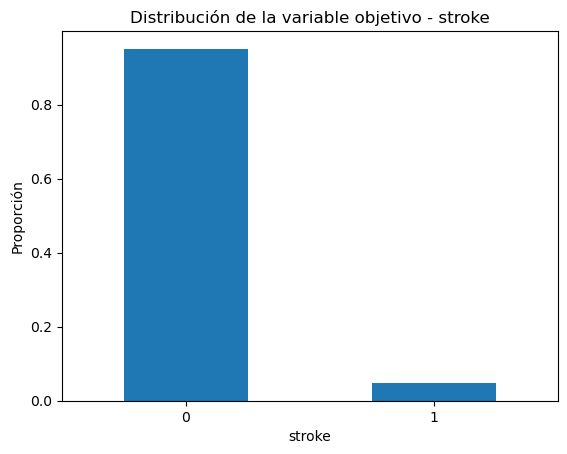

In [61]:
# Distribución de la variable objetivo
stroke_counts = df["stroke"].value_counts(normalize=True)
print(stroke_counts)

plt.figure()
stroke_counts.plot(kind="bar")
plt.title("Distribución de la variable objetivo - stroke")
plt.xticks(rotation=0)
plt.ylabel("Proporción")
plt.show()

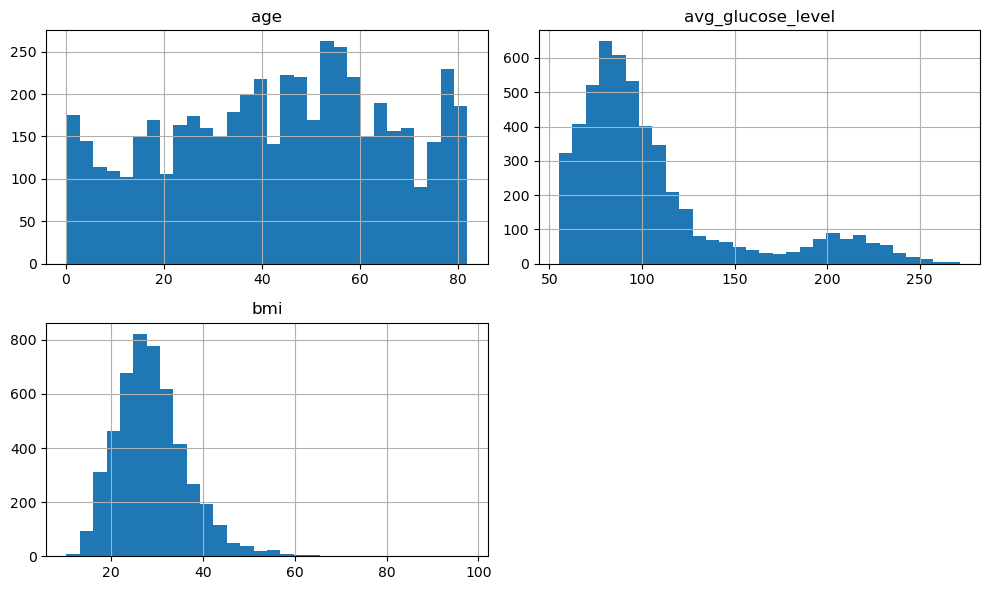

In [62]:
# Histogramas para variables numéricas
df[num_cols].hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

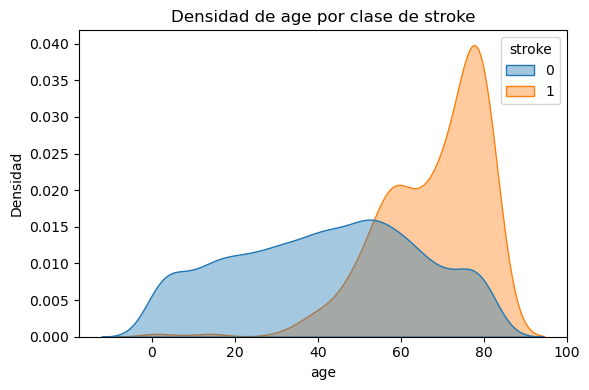

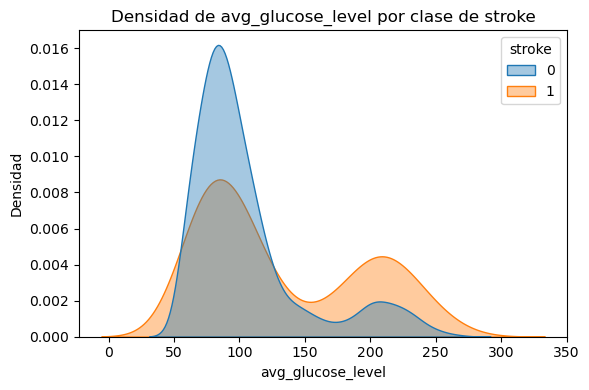

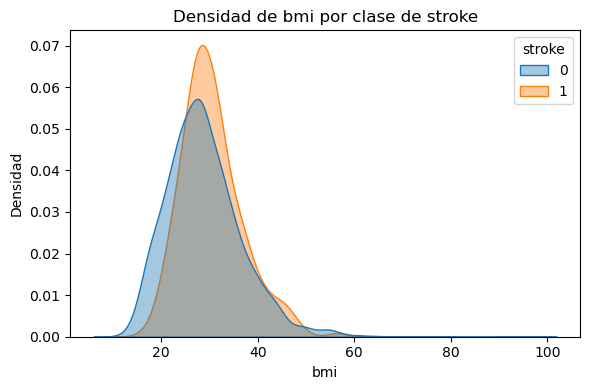

In [63]:
# Densidad de clases (KDE)
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue="stroke", common_norm=False, fill=True, alpha=0.4)
    plt.title(f"Densidad de {col} por clase de stroke")
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()


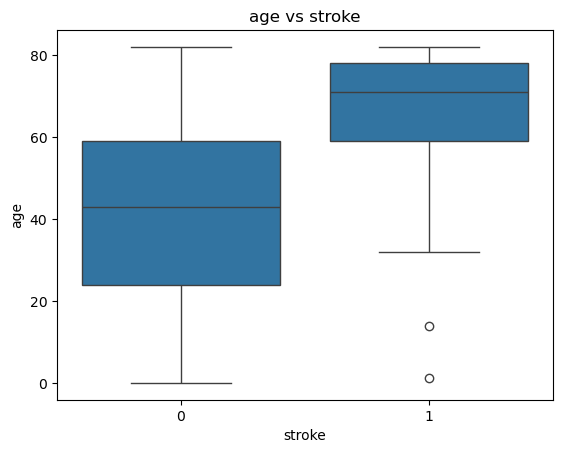

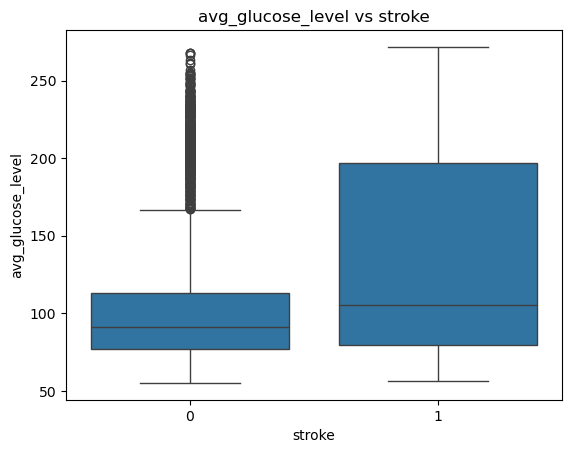

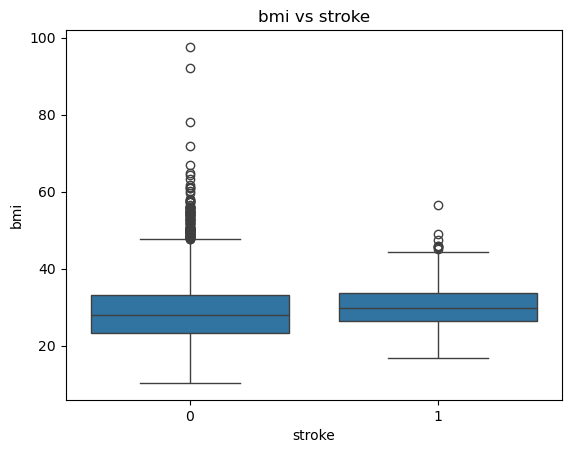

In [64]:
# Boxplots de variables numéricas por clase
for col in num_cols:
    plt.figure()
    sns.boxplot(data=df, x="stroke", y=col)
    plt.title(f"{col} vs stroke")
    plt.show()

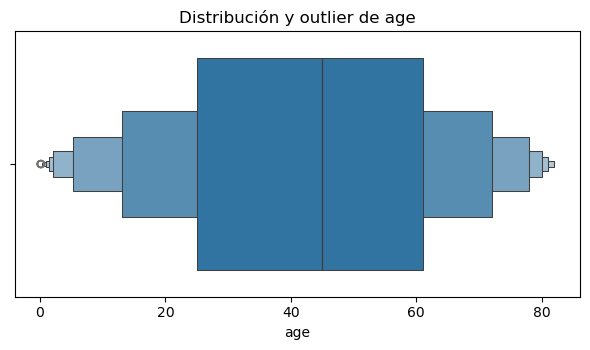

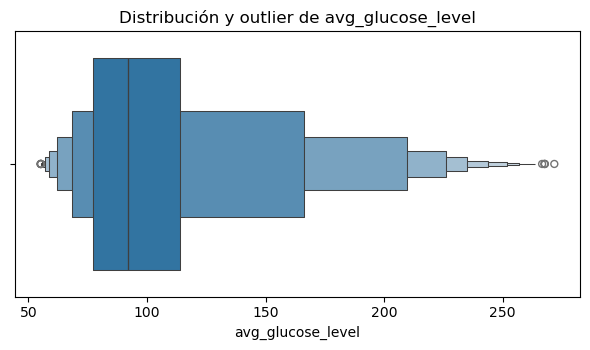

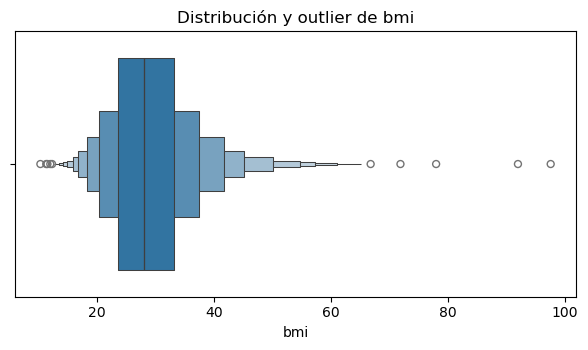

In [65]:
# Outliers con boxenplot
for col in num_cols:
    plt.figure(figsize=(6, 3.6))
    sns.boxenplot(x=df[col])
    plt.title(f"Distribución y outlier de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


Variables categóricas a graficar: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


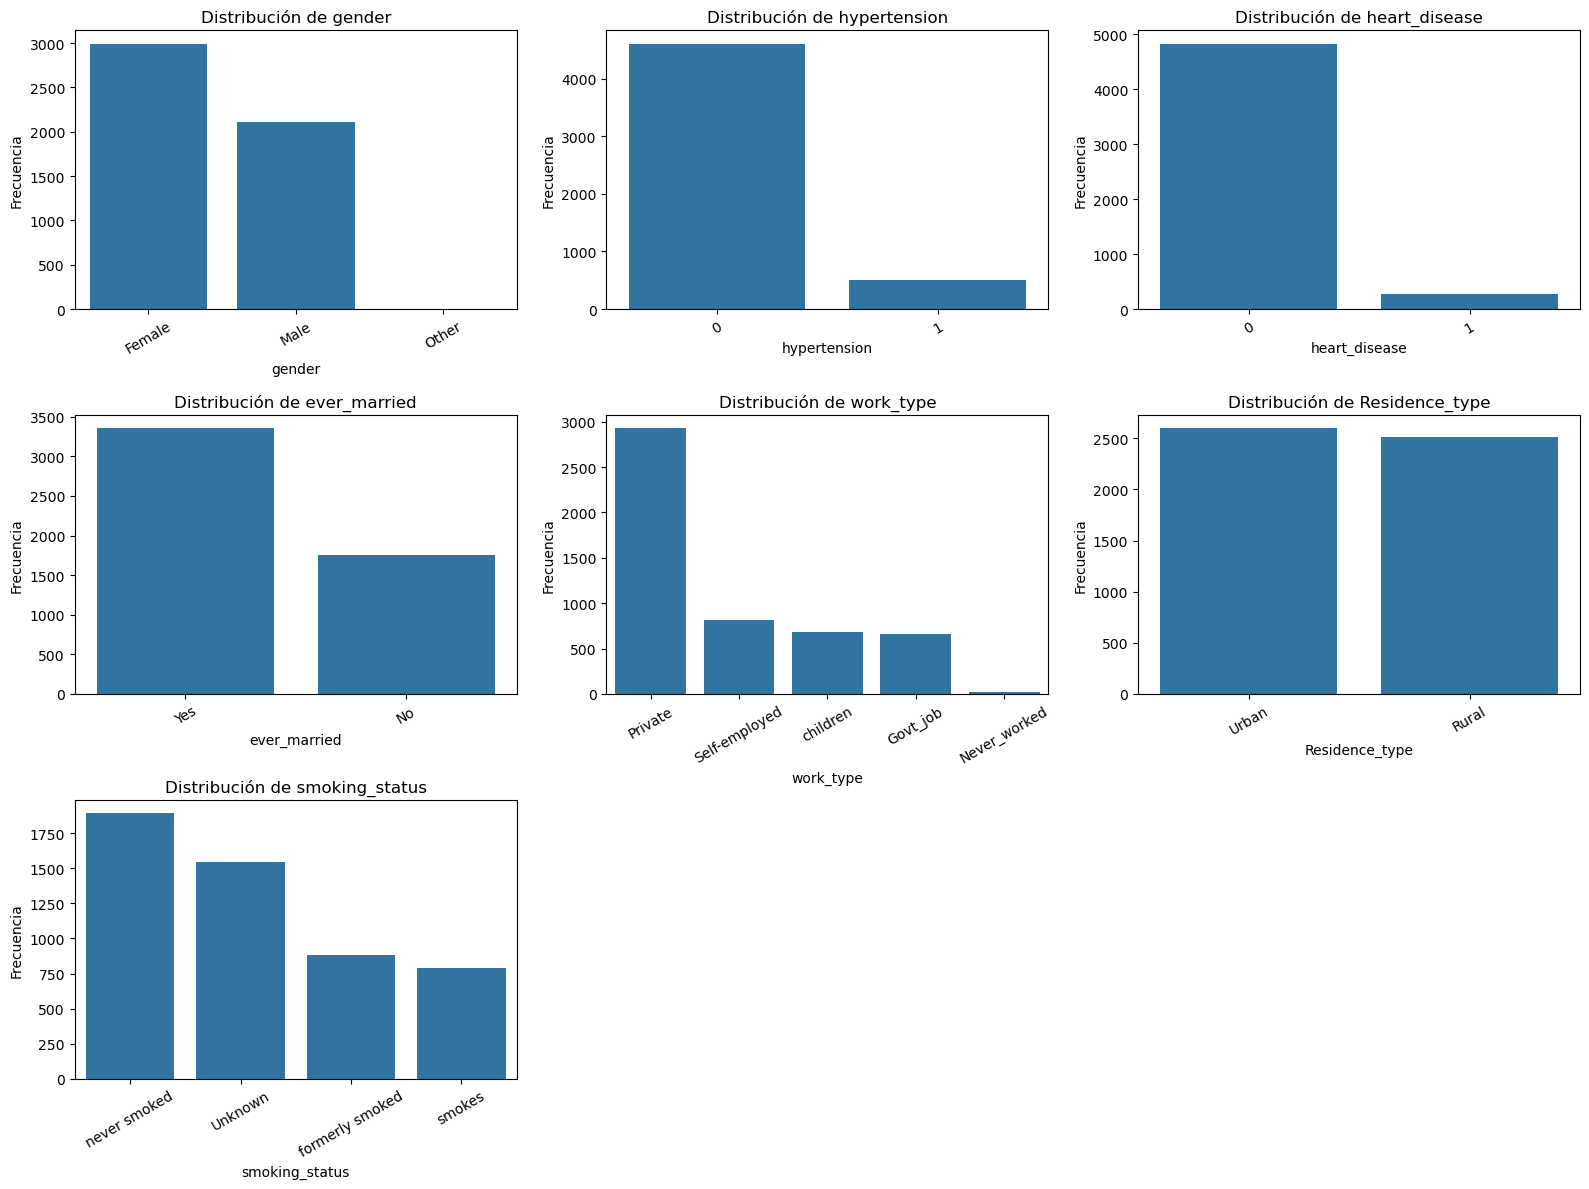

In [66]:
# Distribuciones de variables categóricas

# tratamos también variables binarias numéricas como categóricas
bin_as_cat = ["hypertension", "heart_disease"]
for c in bin_as_cat:
    if c in df.columns and c not in cat_cols:
        cat_cols.append(c)

# Excluimos la variable objetivo si estuviera en la lista por error
cat_cols = [c for c in cat_cols if c != "stroke"]

print("Variables categóricas a graficar:", cat_cols)

# Configuramos una rejilla de subplots
import math
n = len(cat_cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
axes = np.array(axes).reshape(-1)  # aplanamos por conveniencia

for ax, col in zip(axes, cat_cols):
    # Ordenamos las categorías por frecuencia para una lectura más clara
    order = df[col].value_counts(dropna=False).index
    sns.countplot(data=df, x=col, order=order, ax=ax)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")
    ax.tick_params(axis="x", rotation=30)

# Si sobran ejes vacíos (cuando n no es múltiplo de ncols), los escondemos
for ax in axes[len(cat_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


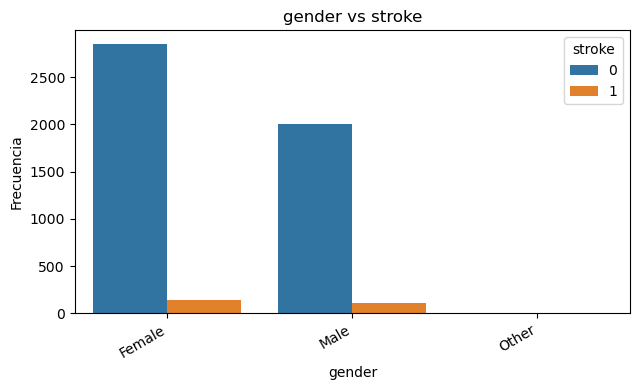

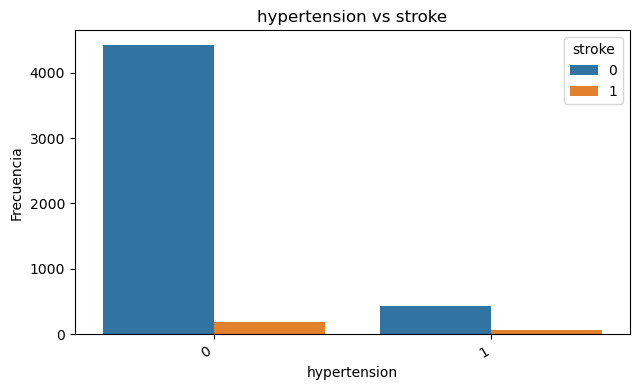

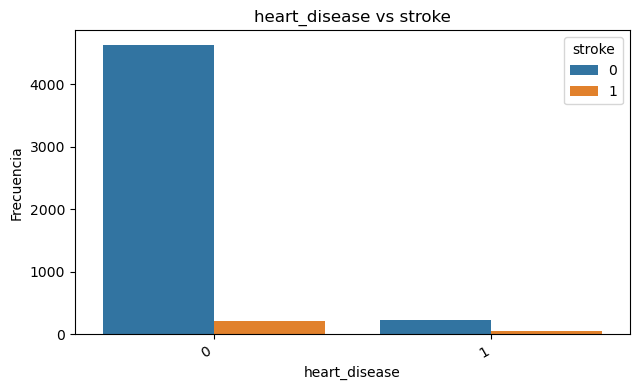

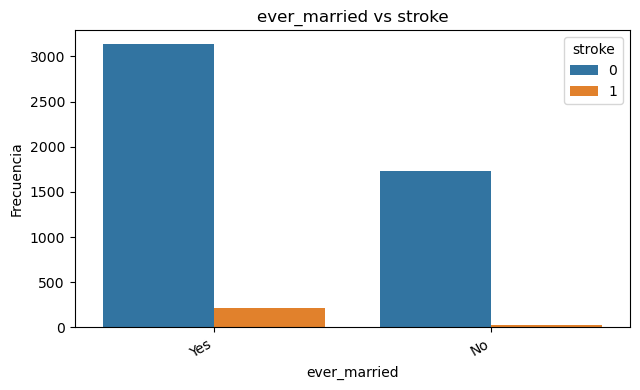

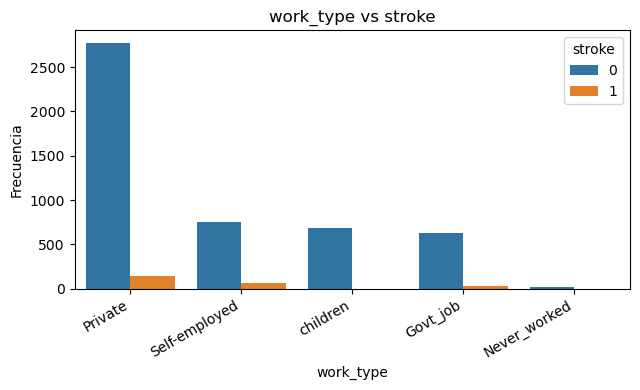

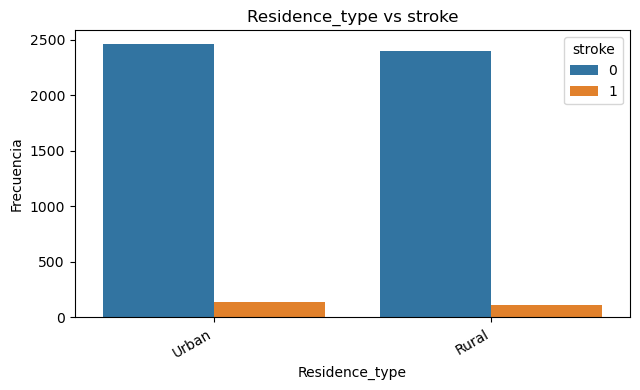

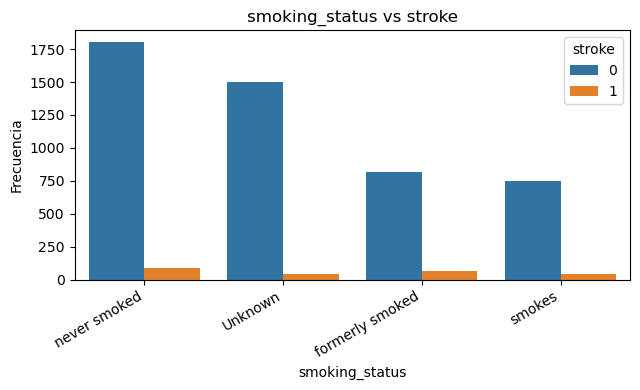

In [67]:
# Barplots de variables categóricas por clase

for col in cat_cols:
    plt.figure(figsize=(6.5, 4))
    # Ordenamos las categorías por frecuencia total para una lectura más clara
    order = df[col].value_counts(dropna=False).index
    
    # countplot con 'stroke' como hue para ver la distribución por clase
    sns.countplot(data=df, x=col, hue="stroke", order=order)
    
    # Títulos y ejes
    plt.title(f"{col} vs stroke")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


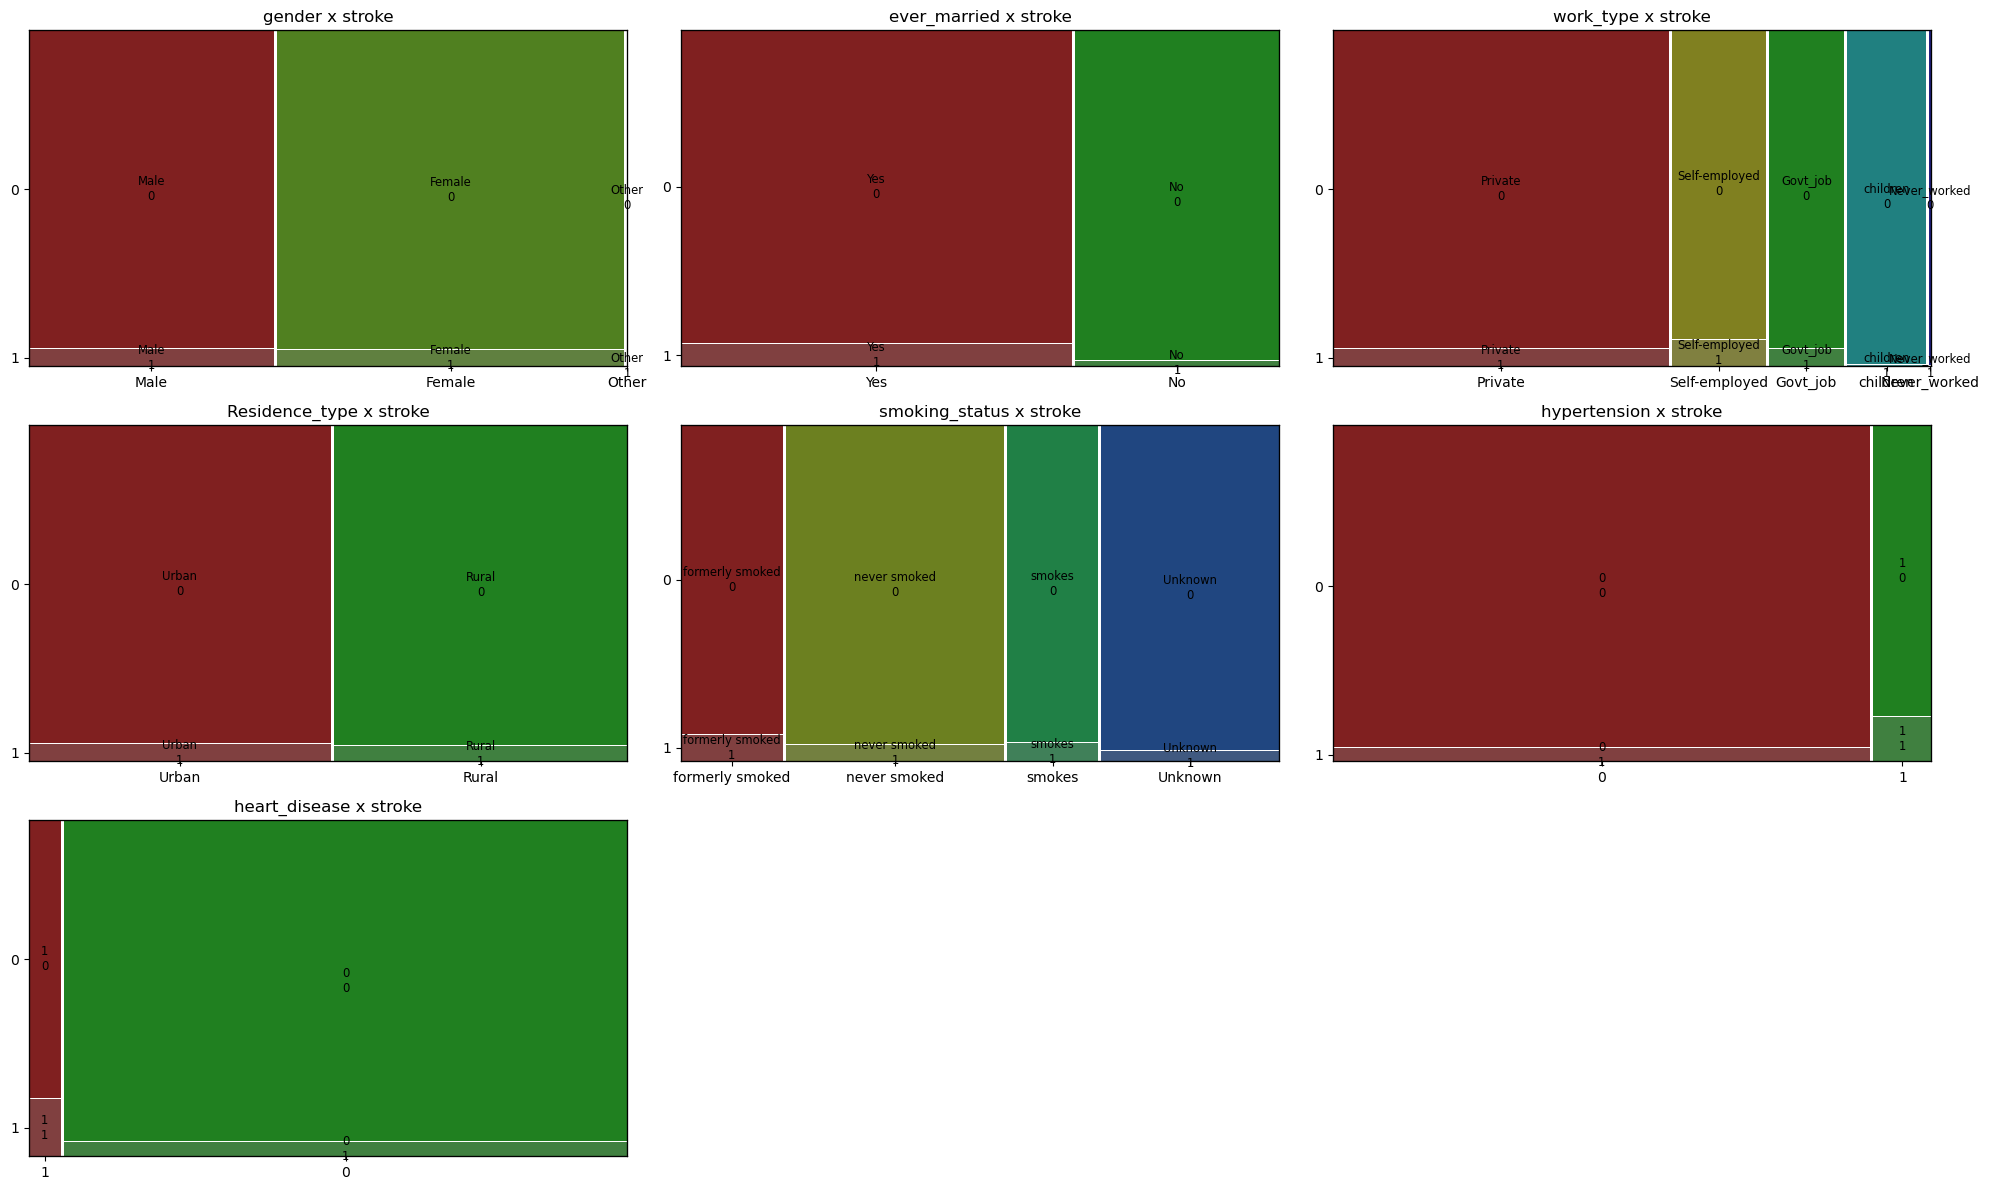

In [68]:
# Mosaic plots
from statsmodels.graphics.mosaicplot import mosaic
import math, os

# Seleccionamos categóricas (tipo 'object') y añadimos binarias numéricas
cat_base = [c for c in df.columns if df[c].dtype == "object"]
bin_as_cat = ["hypertension", "heart_disease"]
cat_cols = cat_base + [c for c in bin_as_cat if c in df.columns]

# Excluimos la variable objetivo para esta sección
cat_vs_stroke = [c for c in cat_cols if c != "stroke"]

# Rejilla de subplots
n = len(cat_vs_stroke); ncols = 3; nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4*nrows))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, cat_vs_stroke):
    # Filtramos filas con NaN en las dos columnas para evitar errores del mosaic
    dpair = df[[col, "stroke"]].dropna()
    # Dibujamos el mosaic en el eje actual
    mosaic(dpair, index=[col, "stroke"], ax=ax)
    ax.set_title(f"{col} x stroke")

# Si sobran ejes, los ocultamos
for ax in axes[len(cat_vs_stroke):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### 4. Limpieza y preparación de datos

In [69]:
# Reemplazar strings de ‘N/A’ por NaN
df.replace({"N/A": np.nan, "?": np.nan}, inplace=True)

# Convertir tipos
numeric_cols = ["age", "avg_glucose_level", "bmi"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Eliminamos filas con género "Other" si las hubiera
if (df["gender"] == "Other").any():
    df = df[df["gender"] != "Other"].copy()

print(f"Dataset limpio: {df.shape}")

df.head()

Dataset limpio: (5109, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,6.700e+01,0,1,Yes,Private,Urban,2.287e+02,3.660e+01,formerly smoked,1
51676,Female,6.100e+01,0,0,Yes,Self-employed,Rural,2.022e+02,NaN,never smoked,1
31112,Male,8.000e+01,0,1,Yes,Private,Rural,1.059e+02,3.250e+01,never smoked,1
60182,Female,4.900e+01,0,0,Yes,Private,Urban,1.712e+02,3.440e+01,smokes,1
1665,Female,7.900e+01,1,0,Yes,Self-employed,Rural,1.741e+02,2.400e+01,never smoked,1


### 5. Contrastes de hipótesis

In [70]:
# Contrastes de hipótesis (con FDR)
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact, pointbiserialr
from statsmodels.stats.multitest import multipletests
pd.options.display.float_format = '{:.3e}'.format

target = "stroke"

# Numéricas vs stroke: Welch + Mann–Whitney + tamaño del efecto 
def cohens_d(x, y):
    """Cohen's d con varianza combinada; x = grupo stroke=1, y = grupo stroke=0."""
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    s = np.sqrt(((nx - 1)*vx + (ny - 1)*vy) / (nx + ny - 2))
    return np.nan if s == 0 else (x.mean() - y.mean()) / s

print("\n=== Pruebas para variables numéricas ===")
rows = []
for col in num_cols:
    x = df.loc[df[target] == 1, col].dropna()
    y = df.loc[df[target] == 0, col].dropna()
    if x.empty or y.empty:
        continue
    t_stat, p_t = ttest_ind(x, y, equal_var=False)                 # Welch
    u_stat, p_u = mannwhitneyu(x, y, alternative="two-sided")      # No paramétrica
    d = cohens_d(x, y)
    rows.append({"variable": col, "t_Welch": t_stat, "p_t": p_t,
                 "U_MW": u_stat, "p_u": p_u, "Cohen_d": d})
num_tests = pd.DataFrame(rows)
print(num_tests.round(4))

# Ajuste FDR para las numéricas (tratamos p_t y p_u como dos familias)
if not num_tests.empty:
    num_tests["p_t_fdr"] = multipletests(num_tests["p_t"], method="fdr_bh")[1]
    num_tests["p_u_fdr"] = multipletests(num_tests["p_u"], method="fdr_bh")[1]
    num_tests = num_tests.sort_values("p_t_fdr")
    print("\n=== Numéricas (con FDR) ===")
    print(num_tests.round(4))

# Categóricas vs stroke: χ² + V de Cramér; OR y Fisher si 2×2
def cramers_v(contingency):
    """Cramér's V para tablas rxk."""
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.values.sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_rows = []
for col in cat_cols:
    cont = pd.crosstab(df[col], df[target])
    if cont.empty or cont.shape[0] < 2:
        continue
    chi2, p, dof, expected = chi2_contingency(cont)
    n = cont.values.sum()
    V = np.sqrt(chi2 / (n * (min(cont.shape) - 1)))
    row = {"variable": col, "chi2": chi2, "dof": dof, "p_chi2": p,
           "cramers_V": V, "tiny_expected": bool((expected < 5).any())}

    # Si es una tabla 2×2, añadimos OR, IC95% y Fisher
    if cont.shape == (2, 2):
        a, b = cont.iloc[0, 0], cont.iloc[0, 1]
        c, d = cont.iloc[1, 0], cont.iloc[1, 1]
        # Corrección de Haldane–Anscombe si hay ceros
        if min(a, b, c, d) == 0:
            a += 0.5; b += 0.5; c += 0.5; d += 0.5
        OR = (a * d) / (b * c)
        se_logOR = np.sqrt(1/a + 1/b + 1/c + 1/d)
        ci_low = np.exp(np.log(OR) - 1.96*se_logOR)
        ci_high = np.exp(np.log(OR) + 1.96*se_logOR)
        _, p_fisher = fisher_exact([[a, b], [c, d]], alternative="two-sided")
        row.update({"OR": OR, "OR_CI95_low": ci_low, "OR_CI95_high": ci_high, "p_fisher": p_fisher})

    cat_rows.append(row)

cat_tests = pd.DataFrame(cat_rows)

# Ajuste FDR para p del χ² y, si existe, para p de Fisher (solo 2×2)
if not cat_tests.empty:
    cat_tests["p_chi2_fdr"] = multipletests(cat_tests["p_chi2"], method="fdr_bh")[1]
    if "p_fisher" in cat_tests.columns:
        mask_2x2 = cat_tests["p_fisher"].notna()
        if mask_2x2.any():
            cat_tests.loc[mask_2x2, "p_fisher_fdr"] = multipletests(
                cat_tests.loc[mask_2x2, "p_fisher"], method="fdr_bh"
            )[1]
    cat_tests = cat_tests.sort_values("p_chi2_fdr")
    print("\n=== Categóricas (con FDR) ===")
    print(cat_tests.round(4))

# Medidas de correlación solicitadas por la guía
print("\n=== Correlaciones entre numéricas (Spearman) ===")
print(df[num_cols].corr(method="spearman").round(3))

# Point-biserial por variable numérica con FDR
rpb_rows = []
for col in num_cols:
    mask = df[col].notna() & df[target].notna()
    r, p = pointbiserialr(df.loc[mask, col], df.loc[mask, target])
    rpb_rows.append({"variable": col, "r_pb": r, "p_rpb": p})

rpb_df = pd.DataFrame(rpb_rows)
if not rpb_df.empty:
    rpb_df["p_rpb_fdr"] = multipletests(rpb_df["p_rpb"], method="fdr_bh")[1]
    print("\n=== Point-biserial (con FDR) ===")
    print(rpb_df.round(4))



=== Pruebas para variables numéricas ===
            variable   t_Welch       p_t      U_MW       p_u   Cohen_d
0                age 2.968e+01 0.000e+00 1.010e+06 0.000e+00 1.175e+00
1  avg_glucose_level 6.984e+00 0.000e+00 7.391e+05 0.000e+00 6.183e-01
2                bmi 3.637e+00 3.000e-04 5.688e+05 1.000e-04 2.098e-01

=== Numéricas (con FDR) ===
            variable   t_Welch       p_t      U_MW       p_u   Cohen_d  \
0                age 2.968e+01 0.000e+00 1.010e+06 0.000e+00 1.175e+00   
1  avg_glucose_level 6.984e+00 0.000e+00 7.391e+05 0.000e+00 6.183e-01   
2                bmi 3.637e+00 3.000e-04 5.688e+05 1.000e-04 2.098e-01   

    p_t_fdr   p_u_fdr  
0 0.000e+00 0.000e+00  
1 0.000e+00 0.000e+00  
2 3.000e-04 1.000e-04  

=== Categóricas (con FDR) ===
         variable      chi2  dof    p_chi2  cramers_V  tiny_expected  \
6   heart_disease 9.023e+01    1 0.000e+00  1.329e-01          False   
5    hypertension 8.157e+01    1 0.000e+00  1.264e-01          False   
1    

### 6. Correlaciones

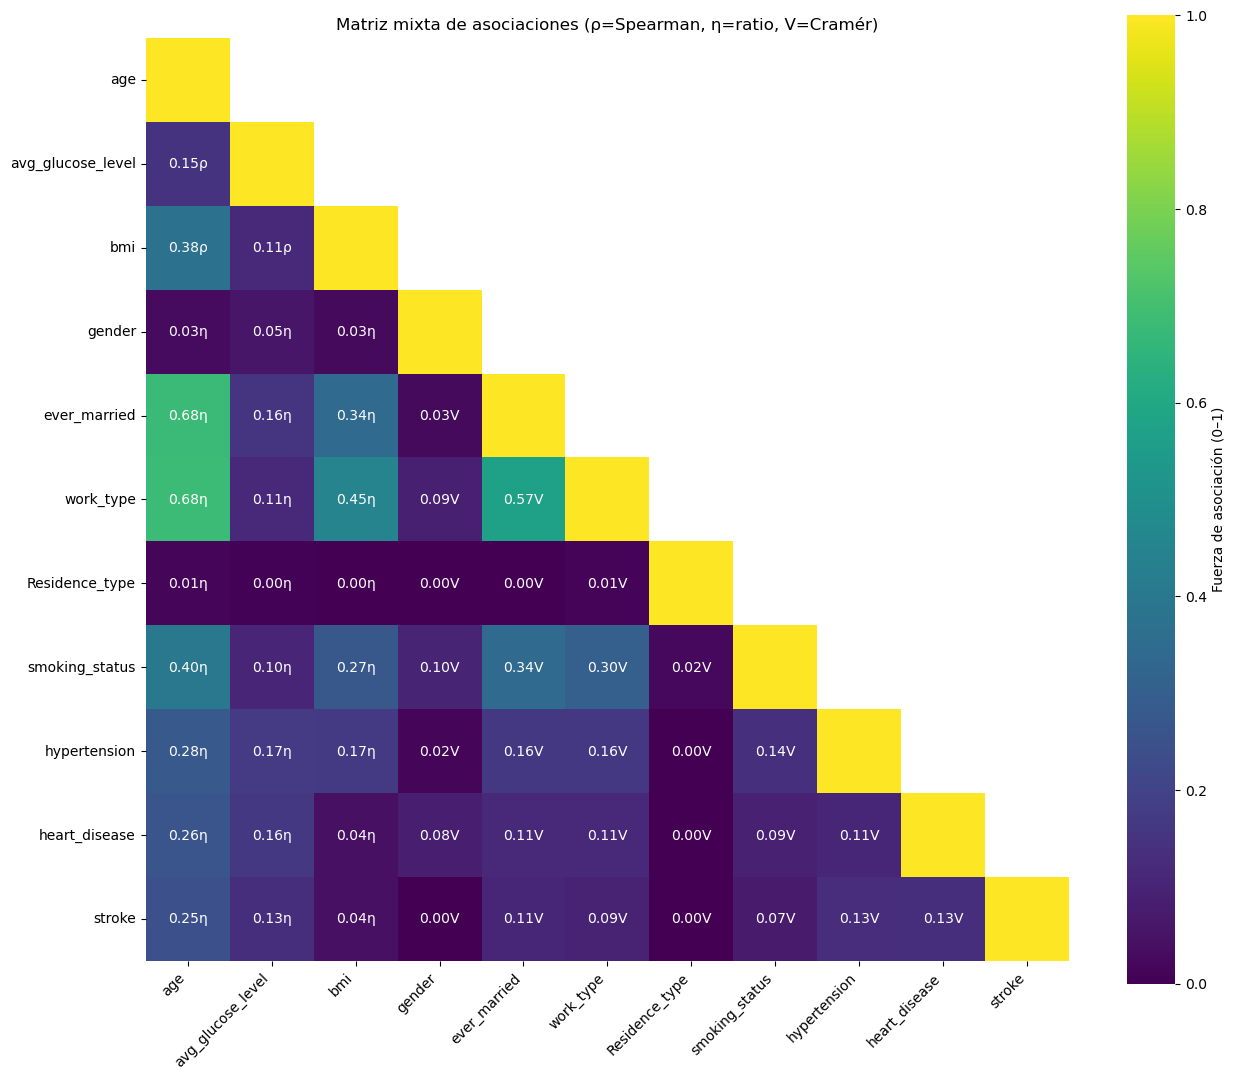

In [71]:
#  Matriz de "correlaciones" 
#    - num↔num: |Spearman ρ|  (0–1, fuerza)
#    - cat↔cat: Cramér's V    (0–1)
#    - num↔cat: η (correlation ratio) (0–1)

from scipy.stats import spearmanr, chi2_contingency

# Aseguramos que 'stroke' esté entre las categóricas (si queremos incluirla en la matriz)
if "stroke" not in cat_cols and "stroke" in df.columns:
    cat_cols = list(cat_cols) + ["stroke"]

# Funciones auxiliares
def cramers_v_corrected(tab):
    """
    V de Cramér con corrección por sesgo (Bergsma, 2013).
    tab: pd.crosstab(...)
    """
    chi2, _, _, _ = chi2_contingency(tab)
    n = tab.values.sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = tab.shape
    # corrección
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0
    r_corr = r - ((r-1)**2)/(n-1) if n > 1 else r
    k_corr = k - ((k-1)**2)/(n-1) if n > 1 else k
    denom = max(1e-12, min(k_corr-1, r_corr-1))
    return np.sqrt(phi2_corr / denom)

def correlation_ratio(categories, measurements):
    """
    η: proporción de varianza explicada por la categórica sobre la numérica.
    Devuelve η en [0,1]. Si no hay variación total, η=0.
    """
    data = pd.DataFrame({"cat": categories, "num": measurements}).dropna()
    if data.empty:
        return np.nan
    groups = data.groupby("cat")["num"]
    means = groups.mean()
    counts = groups.size().astype(float)
    overall = data["num"].mean()
    ss_between = (counts * (means - overall) ** 2).sum()
    ss_total = ((data["num"] - overall) ** 2).sum()
    return 0.0 if ss_total == 0 else float(np.sqrt(ss_between / ss_total))

bin_as_cat = ["hypertension", "heart_disease", "bmi_missing"]
cat_cols_full = list(dict.fromkeys(
    list(cat_cols) + [c for c in bin_as_cat if c in df.columns] + ["stroke"]
))

# Reconstruimos la lista final (numéricas primero, luego categóricas)
all_vars = list(dict.fromkeys(list(num_cols) + cat_cols_full))

# Matrices de valores y de etiquetas (método usado)
n = len(all_vars)
vals = np.zeros((n, n), dtype=float)
labs = np.empty((n, n), dtype=object)

for i, a in enumerate(all_vars):
    for j, b in enumerate(all_vars):
        if i == j:
            vals[i, j] = 1.0
            labs[i, j] = ""
            continue

        a_is_num = a in num_cols
        b_is_num = b in num_cols
        a_is_cat = a in cat_cols_full
        b_is_cat = b in cat_cols_full

        # num ↔ num: |Spearman|
        if a_is_num and b_is_num:
            r, _ = spearmanr(df[a], df[b], nan_policy="omit")
            val = np.abs(r) if pd.notna(r) else np.nan
            lab = "ρ"

        # cat ↔ cat: Cramér's V
        elif a_is_cat and b_is_cat:
            tab = pd.crosstab(df[a], df[b])
            val = cramers_v_corrected(tab)
            lab = "V"

        # mixto: num ↔ cat → η
        else:
            if a_is_cat and b_is_num:
                cat, num = df[a], df[b]
            else:
                cat, num = df[b], df[a]
            val = correlation_ratio(cat, num)
            lab = "η"

        vals[i, j] = val
        labs[i, j] = lab

# DataFrames con índices/columnas
vals_df = pd.DataFrame(vals, index=all_vars, columns=all_vars)
labs_df = pd.DataFrame(labs, index=all_vars, columns=all_vars)

# mostramos solo el triángulo inferior para evitar duplicados
mask_upper = np.triu(np.ones_like(vals_df, dtype=bool), k=1)
annot_df = vals_df.copy().astype(object)
for r in range(n):
    for c in range(n):
        if mask_upper[r, c]:
            annot_df.iat[r, c] = ""
        else:
            # Etiqueta con valor y símbolo del método (ej. "0.45η")
            annot_df.iat[r, c] = "" if r == c else f"{vals_df.iat[r, c]:.2f}{labs_df.iat[r, c]}"

# Heatmap (escala 0–1 = fuerza de asociación)
plt.figure(figsize=(1.2*n, 1.0*n))  # tamaño proporcional al número de variables
sns.heatmap(
    vals_df, vmin=0, vmax=1, cmap="viridis",
    annot=annot_df, fmt="", square=True,
    mask=mask_upper, cbar_kws={"label": "Fuerza de asociación (0–1)"}
)
plt.title("Matriz mixta de asociaciones (ρ=Spearman, η=ratio, V=Cramér)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 7. Ingeniería de características y separación Train/Test

In [ ]:
# Listas de variables por tipo
num_cont_features = ["age", "avg_glucose_level", "bmi"]        # continuas → imputación mediana + escalado
num_bin_features  = ["hypertension", "heart_disease"]          # binarias → imputación por moda (sin escalado)
cat_features      = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]  # categóricas → OHE

# Matriz X/y
X = df.drop(columns=["stroke"]).copy()
y = df["stroke"].astype(int)


print("Numéricas continuas:", num_cont_features)
print("Numéricas binarias :", num_bin_features)
print("Categóricas        :", cat_features)

# Train/Test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print(f"Train shape: {X_train.shape}  |  Test shape: {X_test.shape}")
print("Prevalencia en train:", y_train.mean().round(4), " | en test:", y_test.mean().round(4))

# Preprocesador por tipo de variable
numeric_cont_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

numeric_bin_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))  # sin escalado
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num_cont", numeric_cont_transformer, num_cont_features),
        ("num_bin",  numeric_bin_transformer,  num_bin_features),
        ("cat",      categorical_transformer,  cat_features),
    ],
    verbose_feature_names_out=False,
    remainder="drop"
)

# >>> NO transformamos aquí. El ajuste y la transformación se harán DENTRO de la pipeline del modelo (Sección 8).


Numéricas continuas: ['age', 'avg_glucose_level', 'bmi']
Numéricas binarias : ['hypertension', 'heart_disease']
Categóricas        : ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Train shape: (4087, 10)  |  Test shape: (1022, 10)
Prevalencia en train: 0.0487  | en test: 0.0489


### 8. Definición y entrenamiento de modelos

In [86]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from scipy.stats import randint, loguniform

# CV estratificada y métrica(s)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision"}  # PR-AUC = area bajo curva precisión-recall

# Transformador para densificar (por si el OHE produce matrices dispersas)
to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X, accept_sparse=True)

# Definimos los modelos base dentro de una imblearn.Pipeline:
#     preprocesador -> to_dense -> SMOTE -> clasificador
base_pipelines = {
    "Logistic Regression": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("to_dense",  to_dense),
        ("smote",     SMOTE(random_state=RANDOM_STATE)),
        ("clf",       LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "Random Forest": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("to_dense",  to_dense),
        ("smote",     SMOTE(random_state=RANDOM_STATE)),
        ("clf",       RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "Gradient Boosting": ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("to_dense",  to_dense),
        ("smote",     SMOTE(random_state=RANDOM_STATE)),
        ("clf",       GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

# Espacios de búsqueda (hiperparámetros van con prefijo 'clf__' y 'smote__')
search_spaces = {
    "Logistic Regression": {
        "clf__C": loguniform(1e-3, 10),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "saga"],
        "smote__k_neighbors": randint(3, 8)
    },
    "Random Forest": {
        "clf__n_estimators": randint(200, 600),
        "clf__max_depth": randint(3, 20),
        "clf__min_samples_split": randint(2, 11),
        "clf__min_samples_leaf": randint(1, 8),
        "clf__max_features": ["sqrt", "log2", None],
        "smote__k_neighbors": randint(3, 8)
    },
    "Gradient Boosting": {
        "clf__n_estimators": randint(200, 600),
        "clf__learning_rate": loguniform(0.01, 0.3),
        "clf__max_depth": randint(2, 6),
        "clf__subsample": [0.6, 0.8, 1.0],
        "smote__k_neighbors": randint(3, 8)
    }
}

# Búsqueda aleatoria con scoring múltiple (refit=roc_auc)
best_models = {}
cv_results = {}

for name, pipe in base_pipelines.items():
    print(f"\nBúsqueda de hiperparámetros para {name} …")
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=search_spaces[name],
        n_iter=30,
        scoring=scoring,
        refit="roc_auc",
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    # Resumen de CV
    res = search.cv_results_
    auc_cv   = res["mean_test_roc_auc"][search.best_index_]
    prauc_cv = res["mean_test_pr_auc"][search.best_index_]
    cv_results[name] = {"roc_auc_cv": auc_cv, "pr_auc_cv": prauc_cv, "best_params": search.best_params_}

    print(f"Mejor ROC-AUC CV = {auc_cv:.3f} | Mejor PR-AUC CV = {prauc_cv:.3f}")
    print(f"Mejores params: {search.best_params_}")

cv_df = (pd.DataFrame(cv_results).T
         .sort_values("roc_auc_cv", ascending=False))
print("\nResumen CV tras tuning (refit=ROC-AUC):")
display(cv_df[["roc_auc_cv", "pr_auc_cv"]])


Búsqueda de hiperparámetros para Logistic Regression …
Mejor ROC-AUC CV = 0.838 | Mejor PR-AUC CV = 0.187
Mejores params: {'clf__C': np.float64(0.034806953267852714), 'clf__penalty': 'l2', 'clf__solver': 'saga', 'smote__k_neighbors': 7}

Búsqueda de hiperparámetros para Random Forest …
Mejor ROC-AUC CV = 0.812 | Mejor PR-AUC CV = 0.149
Mejores params: {'clf__max_depth': 3, 'clf__max_features': None, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 9, 'clf__n_estimators': 492, 'smote__k_neighbors': 5}

Búsqueda de hiperparámetros para Gradient Boosting …
Mejor ROC-AUC CV = 0.810 | Mejor PR-AUC CV = 0.153
Mejores params: {'clf__learning_rate': np.float64(0.012413189635294229), 'clf__max_depth': 4, 'clf__n_estimators': 261, 'clf__subsample': 0.6, 'smote__k_neighbors': 5}

Resumen CV tras tuning (refit=ROC-AUC):


,roc_auc_cv,pr_auc_cv
Logistic Regression,8.384e-01,1.874e-01
Random Forest,8.123e-01,1.492e-01
Gradient Boosting,8.101e-01,1.528e-01


### 9. Evaluación en test set

<Figure size 600x400 with 0 Axes>

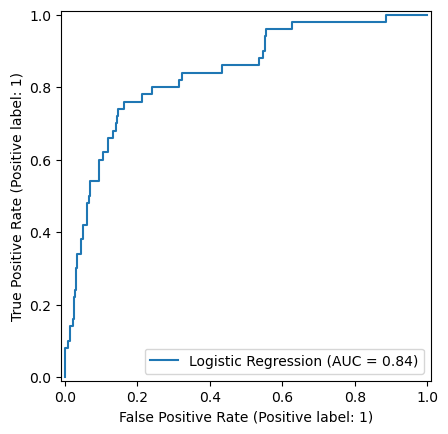

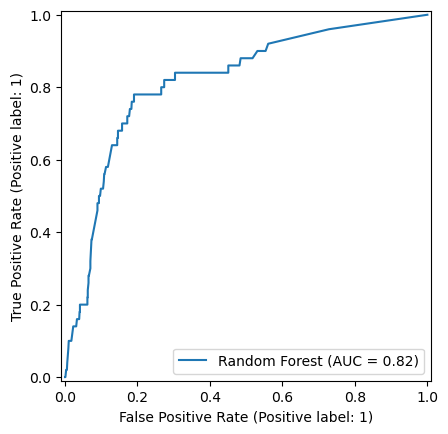

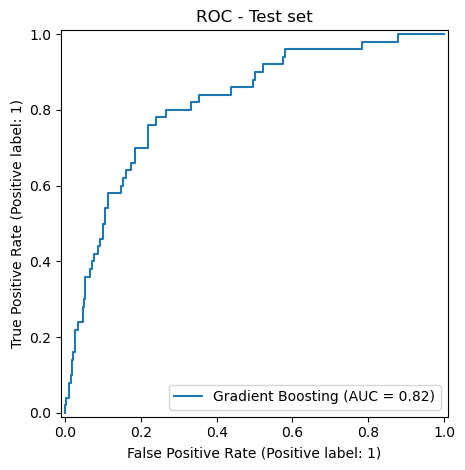

<Figure size 600x400 with 0 Axes>

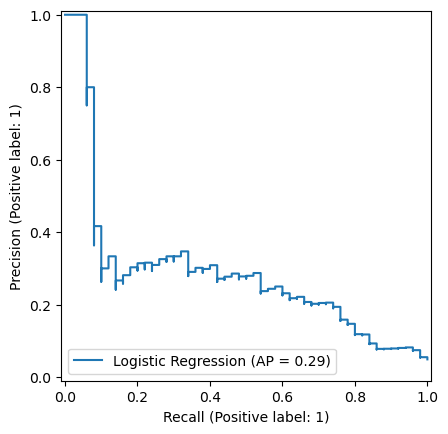

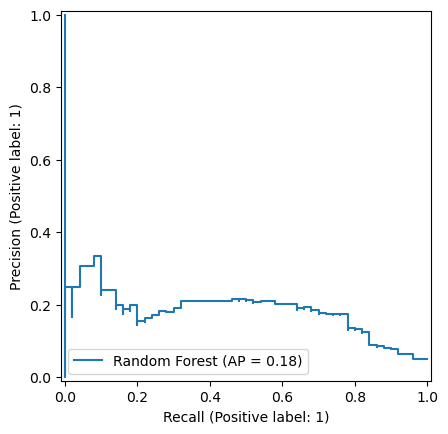

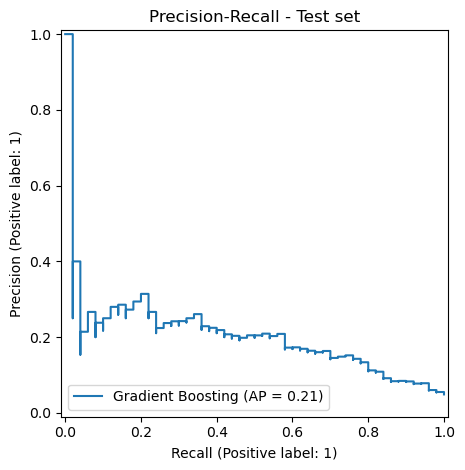

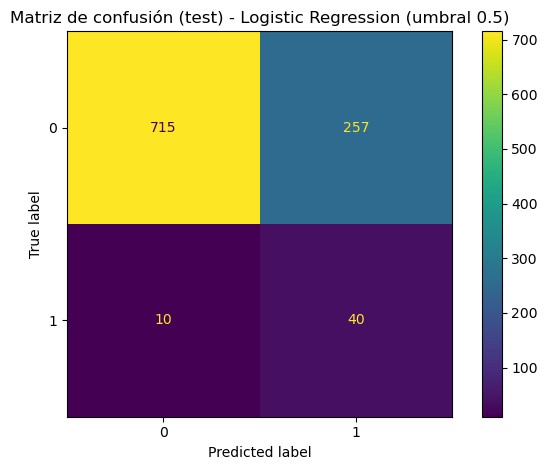

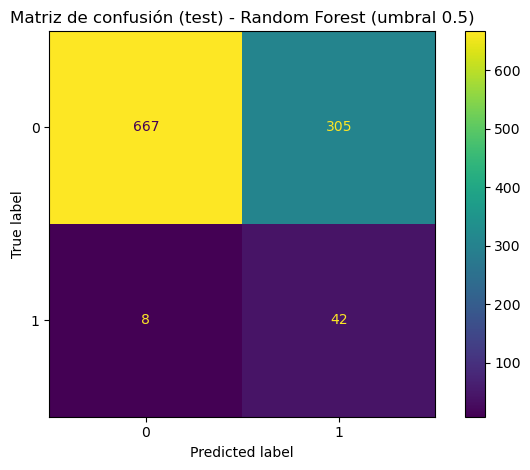

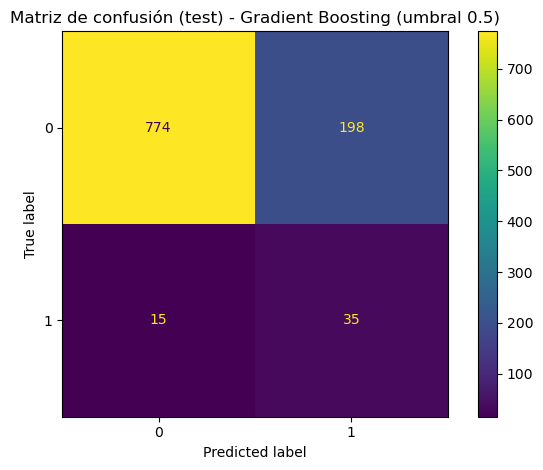


Resultados en test (umbral 0.5):


,accuracy,precision,recall,specificity,f1,roc_auc,pr_auc
Logistic Regression,7.387e-01,1.347e-01,8.000e-01,7.356e-01,2.305e-01,8.397e-01,2.887e-01
Random Forest,6.937e-01,1.210e-01,8.400e-01,6.862e-01,2.116e-01,8.172e-01,1.826e-01
Gradient Boosting,7.916e-01,1.502e-01,7.000e-01,7.963e-01,2.473e-01,8.168e-01,2.083e-01


In [74]:
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
                             ConfusionMatrixDisplay)

metrics = {}

# Curva ROC
plt.figure(figsize=(6, 4))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]        # probabilidades clase positiva
    y_pred  = (y_proba >= 0.5).astype(int)             # umbral por defecto 0.5

    # Métricas
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    metrics[name] = {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred, zero_division=0),
        "specificity": specificity,
        "f1":        f1_score(y_test, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_test, y_proba),
        "pr_auc":    average_precision_score(y_test, y_proba)   # área PR (Average Precision)
    }

    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)

plt.title("ROC - Test set")
plt.tight_layout()
plt.show()

# Curva Precisión-Recall (más informativa en desbalance)
plt.figure(figsize=(6, 4))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    PrecisionRecallDisplay.from_predictions(y_test, y_proba, name=name)

plt.title("Precision-Recall - Test set")
plt.tight_layout()
plt.show()

# Matrices de confusión por modelo (umbral 0.5)
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Matriz de confusión (test) - {name} (umbral 0.5)")
    plt.tight_layout()
    plt.show()

# Tabla de resultados
results_df = (pd.DataFrame(metrics)
              .T
              .sort_values(["roc_auc", "pr_auc"], ascending=False))
print("\nResultados en test (umbral 0.5):")
display(results_df.round(4))


### 10. Interpretación: importancia de características

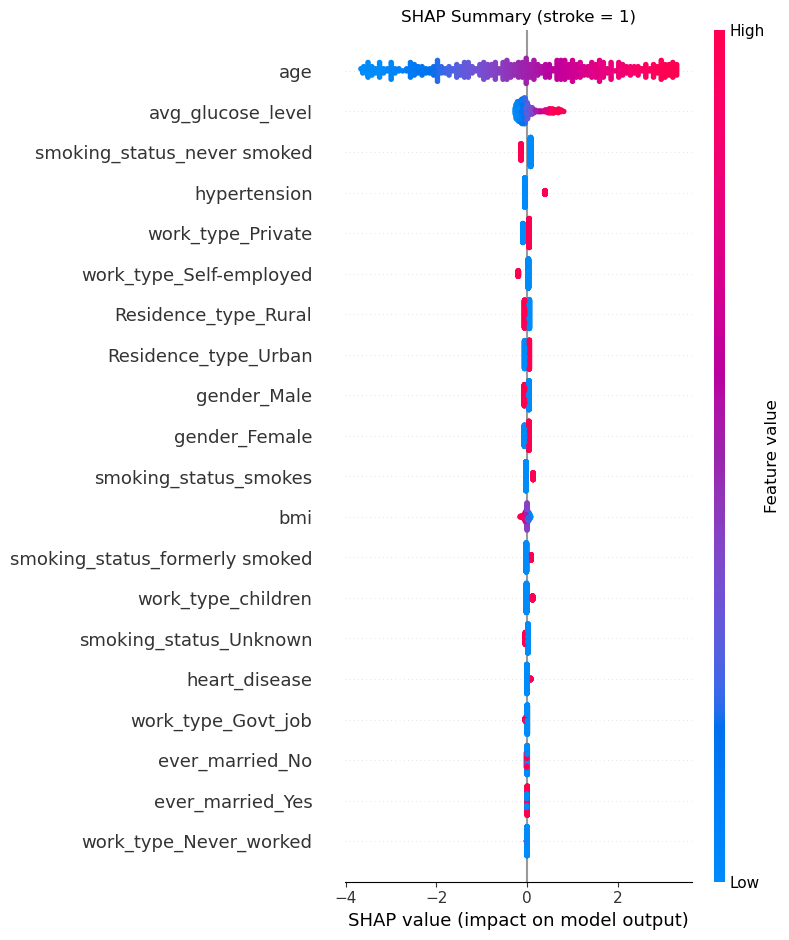


Ranking global por impacto medio |SHAP|:


,feature,mean_|SHAP|
0,age,1.5914
1,avg_glucose_level,0.1764
2,smoking_status_never smoked,0.0977
3,hypertension,0.0881
4,work_type_Private,0.0649
5,work_type_Self-employed,0.0553
6,Residence_type_Rural,0.0519
7,Residence_type_Urban,0.0508
8,gender_Male,0.0485
9,gender_Female,0.0474


<Figure size 700x800 with 0 Axes>

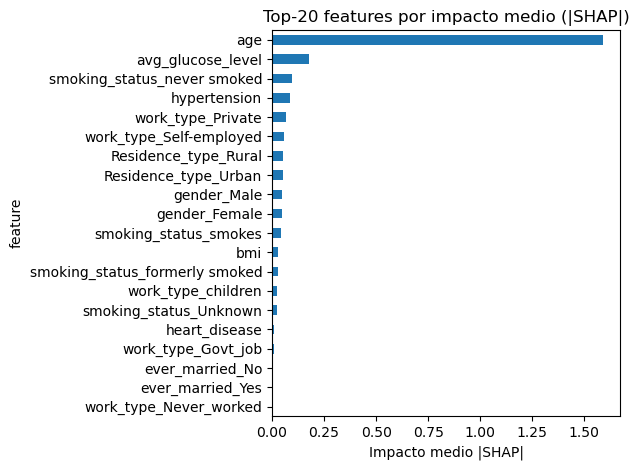

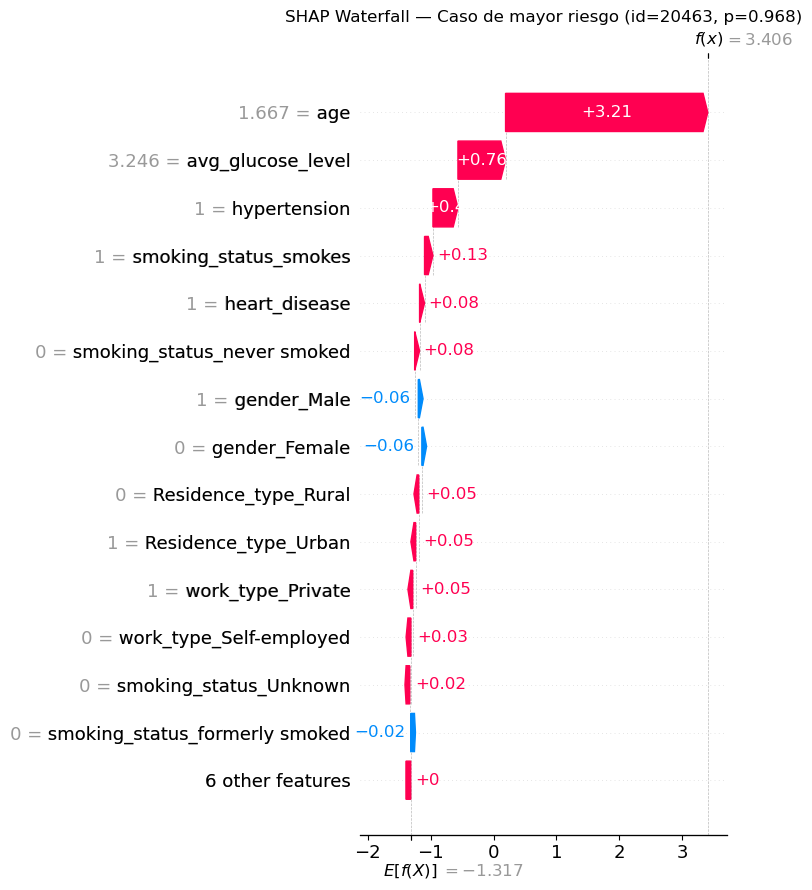

In [90]:
# === Interpretación con SHAP ( ===
# Usamos el preprocesado ajustado y el clasificador RF de la pipeline
import shap  # ensure shap is imported

rf_pipe        = best_models["Logistic Regression"]  # o "Random Forest" o "Gradient Boosting"
preproc_fitted = rf_pipe.named_steps["preprocess"]
rf_clf         = rf_pipe.named_steps["clf"]
feature_names  = preproc_fitted.get_feature_names_out()

# Transformación del test 
X_test_tx   = preproc_fitted.transform(X_test)
X_test_dense = X_test_tx.toarray() if hasattr(X_test_tx, "toarray") else X_test_tx

# Submuestra opcional para acelerar SHAP
n_shap = min(500, X_test_dense.shape[0])
X_shap = X_test_dense[:n_shap, :]

# Elegimos el explainer adecuado según el tipo de modelo
from sklearn.linear_model import LogisticRegression

if isinstance(rf_clf, LogisticRegression) or "LogisticRegression" in type(rf_clf).__name__:
    explainer = shap.LinearExplainer(rf_clf, X_shap, feature_names=feature_names)
    shap_values = explainer.shap_values(X_shap)
else:
    explainer = shap.TreeExplainer(rf_clf)
    shap_values = explainer.shap_values(X_shap)

# Selección segura de la clase positiva (stroke=1) en binario
if isinstance(shap_values, list):
    shap_pos = shap_values[1]
elif getattr(shap_values, "ndim", 0) == 3:
    shap_pos = shap_values[:, :, 1]
else:
    shap_pos = shap_values

# Beeswarm (summary plot) global
shap.summary_plot(shap_pos, X_shap, feature_names=feature_names, show=False, max_display=20)
plt.title("SHAP Summary (stroke = 1)")
plt.tight_layout(); plt.show()

#  Ranking global: media de |SHAP| por feature (tabla y gráfico)
shap_abs_mean = np.abs(shap_pos).mean(axis=0)
shap_rank = (pd.DataFrame({"feature": feature_names, "mean_|SHAP|": shap_abs_mean})
             .sort_values("mean_|SHAP|", ascending=False)
             .reset_index(drop=True))

print("\nRanking global por impacto medio |SHAP|:")
display(shap_rank.head(20).style.format({"mean_|SHAP|": "{:.4f}"}))

plt.figure(figsize=(7, 8))
(shap_rank.head(20)
 .plot.barh(x="feature", y="mean_|SHAP|", legend=False))
plt.gca().invert_yaxis()
plt.xlabel("Impacto medio |SHAP|")
plt.title("Top-20 features por impacto medio (|SHAP|)")
plt.tight_layout(); plt.show()

# --- Elegimos el caso de mayor riesgo predicho ---
probas_test = rf_pipe.predict_proba(X_test)[:, 1]
i_top = int(np.argsort(probas_test)[-1])

idx = X_test.index[i_top]
x_row_dense = X_test_dense[i_top, :].reshape(1, -1)  # 1xF para el explainer

# Recalculamos SHAP SOLO para esa fila (evita el desajuste con X_shap)
shap_row_all = explainer.shap_values(x_row_dense)

# Extraemos la clase positiva de forma robusta
if isinstance(shap_row_all, list):
    shap_row = shap_row_all[1].reshape(-1)          # (F,)
elif getattr(shap_row_all, "ndim", 0) == 3:
    shap_row = shap_row_all[:, :, 1].reshape(-1)    # (F,)
else:
    shap_row = shap_row_all.reshape(-1)             # (F,)

# expected_value puede ser escalar o vector; forzamos a escalar (clase positiva si existe)
ev = np.atleast_1d(explainer.expected_value)
base_val = float(ev[1] if ev.size > 1 else ev[0])

# Construimos la Explanation explícitamente
exp = shap.Explanation(
    values=shap_row,
    base_values=base_val,
    data=x_row_dense.reshape(-1),     # vector (F,)
    feature_names=feature_names
)

ax = shap.plots.waterfall(exp, max_display=min(15, len(feature_names)), show=False)
ax.set_title(f"SHAP Waterfall — Caso de mayor riesgo (id={idx}, p={probas_test[i_top]:.3f})")
plt.tight_layout(); plt.show()



### 11. Guardado del modelo ganador

In [82]:
# Defina una función de nivel superior (picklable)
def densify(X):
    return X.toarray() if hasattr(X, "toarray") else X

from sklearn.preprocessing import FunctionTransformer

# Tome el mejor modelo y reemplace el paso 'to_dense'
best_name = results_df.index[0]
print("El mejor modelo en test:", best_name)

best_pipe = best_models[best_name]
best_pipe.set_params(to_dense=FunctionTransformer(densify, accept_sparse=True))

# Guardamos la pipeline completa con el mejor modelo
BEST_PATH = f"best_stroke_pipeline_{best_name.replace(' ', '_').lower()}_tuned_smote.joblib"
joblib.dump(best_pipe, BEST_PATH)
print("Pipeline guardado en:", BEST_PATH)

El mejor modelo en test: Logistic Regression
Pipeline guardado en: best_stroke_pipeline_logistic_regression_tuned_smote.joblib


In [84]:
import json, sys, sklearn, imblearn, datetime as dt

META_PATH = BEST_PATH.replace(".joblib", "_meta.json")
meta = {
    "model_name": best_name,
    "saved_at": dt.datetime.now().isoformat(timespec="seconds"),
    "features": list(X.columns),
    "versions": {
        "python": sys.version.split()[0],
        "sklearn": sklearn.__version__,
        "imblearn": imblearn.__version__,
        "shap": shap.__version__
    }
}
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)
print("Metadatos guardados en:", META_PATH)


Metadatos guardados en: best_stroke_pipeline_logistic_regression_tuned_smote_meta.json
